<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

<h3>1) Collect data from a reputable source in order use both a simple regression and multiple regression to make prediction and generate prediction intervals in a Colab notebook. You can collect multiple independent variables, or you can "make" the extra independent variable by using a time trend like the video, interactions, or categorical variables. Do not use simulated data for this assignment. Motivate your analysis by explaining why someone might be interested in predicting the dependent variable you use. Please reach out to me if you need to brainstorm data to collect. Come up with some interesting sets of independent variables to make predictions with, and present both the point prediction and associated prediction interval.</h3>


<p>I found a dataset a kaggle user put together by scraping online forms for job postings related to data science.</p>
<a href="https://www.kaggle.com/datasets/elahehgolrokh/data-science-job-postings-with-salaries-2025">2025 Data Science Job Postings</a>

<ul>
<li>job_title → The main keyword in the title of the posted position (e.g., Data Scientist, ML Engineer).
</li>
<li>seniority_level → Seniority of the role (e.g., Junior, Senior, Lead).
</li>
<li>status → Work arrangement type (Remote, Hybrid, On-site).
</li>
<li>company → Anonymized company identifier.
</li>
<li>location → Job location(s) mentioned in the posting.
</li>
<li>post_date → When the job posting was listed.
</li>
<li>headquarter → Location of the company’s headquarters.
</li>
<li>industry → Industry sector of the company (e.g., Finance, Technology).
</li>
<li>ownership → Ownership type (e.g., Public, Private).
</li>
<li>company_size → Number of employees in the company.
</li>
<li>revenue → Reported revenue of the company (if available).
</li>
<li>salary → Annual salary in Euro, expressed as min-max or a single value
</li>
<li>skills → Extracted list of required or preferred skills (e.g., Python, SQL, Spark).</li>
</ul>

<p>We all have a job for one reason and that's money. If you don't work for money you're a lucky person, but for most, money is why we show up to our jobs.</p>
<p>Due to this reason I thought it would be intresting to make my dependent variable salary for data science jobs. </p>

In [141]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [148]:
df = pd.read_csv('../datasets/assignment8/data_science_job_posts_2025.csv')

In [143]:
# Sample exchange rate (you can update this dynamically)
EUR_TO_USD = 1.17

def convert_revenue(value):
    value = str(value)  # Ensure it's a string
    match = re.match(r'€([\d\.]+)([MBT])', value)
    if match:
        num, unit = match.groups()
        multiplier = {'M': 1e6, 'B': 1e9, 'T': 1e12}[unit]
        usd_value = float(num) * multiplier * EUR_TO_USD
        return f"${usd_value:,.2f}"
    return value  # Return original if not matching

def convert_salary(value):
    value = str(value)  # Ensure it's a string
    parts = re.findall(r'€[\d,]+', value)
    if parts:
        converted = []
        for part in parts:
            num = float(part.replace('€', '').replace(',', ''))
            usd = num * EUR_TO_USD
            converted.append(f"${usd:,.0f}")
        return " - ".join(converted)
    return value

df['revenue'] = df['revenue'].fillna("").apply(convert_revenue)
df['salary'] = df['salary'].fillna("").apply(convert_salary)
df = df[df['company_size'].astype(str).str.match(r'^[\d,]+$')] # I lost 40 rows since company size had erroneous euro signs and I didn't want to regex them...

df = df.drop('company', axis=1)

df.head(5)


,job_title,seniority_level,status,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
1,data scientist,lead,hybrid,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030","$59,787,000,000.00","$138,918","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930","$39,546,000,000.00","$111,135 - $186,684","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690","$95,600,700,000.00","$131,972 - $227,450","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"$133,581 - $267,154",[]
5,data scientist,lead,NaN,"New York, NY",3 months ago,"New York, NY, US",Technology,Private,150,"$2,527,200,000.00","$229,754 - $293,869","['scikit-learn', 'python', 'scala', 'sql', 'ma..."


In [144]:
# prints me unique id in a column
for val in df['job_title'].unique():
    print(val)

print('\n')
# df.nunique()
# df.info()
print( df.info(), df.nunique())

data scientist
machine learning engineer
nan
data analyst
data engineer


<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 1 to 943
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        902 non-null    object
 1   seniority_level  845 non-null    object
 2   status           650 non-null    object
 3   location         903 non-null    object
 4   post_date        905 non-null    object
 5   headquarter      905 non-null    object
 6   industry         905 non-null    object
 7   ownership        873 non-null    object
 8   company_size     905 non-null    object
 9   revenue          905 non-null    object
 10  salary           905 non-null    object
 11  skills           905 non-null    object
dtypes: object(12)
memory usage: 91.9+ KB
None job_title            4
seniority_level      4
status               3
location           411
post_date           42
headquarter        194
industry   

salary = beta_0 + beta_1*industry + beta_2*job_title + beta_3*location + beta_4*company_size... every single column seems useful. I just gotta preprocess it. But Now I know that salary is my dependent variable.


In [145]:

# --- Helper functions ---

def clean_salary(salary_str):
    """Convert salary column (single value or range) to numeric midpoint."""
    if pd.isna(salary_str):
        return np.nan
    # Remove dollar signs, commas
    s = salary_str.replace("$", "").replace(",", "")
    # Handle ranges
    if "-" in s:
        low, high = s.split("-")
        return (float(low) + float(high)) / 2
    try:
        return float(s)
    except:
        return np.nan

def clean_revenue(rev_str):
    """Convert revenue string with $ and commas to numeric float, or flag known categories."""
    if pd.isna(rev_str):
        return np.nan

    # Handle known non-numeric labels
    rev_str = rev_str.strip().lower()
    if "private" in rev_str:
        return -1  # Flag for private companies
    elif "public" in rev_str:
        return -2  # Flag for public companies
    elif "education" in rev_str:
        return -3  # Flag for education sector
    elif "nonprofit" in rev_str:
        return -4  # Flag for education sector

    # Remove dollar signs and commas
    s = rev_str.replace("$", "").replace(",", "")
    try:
        return float(s)
    except:
        return np.nan
    
def extract_revenue_type(rev_str):
    if pd.isna(rev_str):
        return "Unknown"
    rev_str = rev_str.strip().lower()
    if "private" in rev_str:
        return "Private"
    elif "public" in rev_str:
        return "Public"
    elif "education" in rev_str:
        return "Education"
    elif "nonprofit" in rev_str:
        return "Nonprofit"
    else:
        return "Numeric"

def days_since_posting(post_date_str):
    """Convert relative dates like '15 days ago', 'a month ago', '2 years ago' to days."""
    if pd.isna(post_date_str):
        return np.nan
    text = post_date_str.lower()

    # Look for a number
    nums = re.findall(r'\d+', text)

    if "day" in text and nums:
        return int(nums[0])
    elif "day" in text:
        return 1  # "a day ago"
    elif "month" in text and nums:
        return int(nums[0]) * 30
    elif "month" in text:
        return 30  # "a month ago"
    elif "year" in text and nums:
        return int(nums[0]) * 365
    elif "year" in text:
        return 365  # "a year ago"
    else:
        return np.nan
    
def extract_state(location_str):
    """Extract state (US) or country for simplification."""
    if pd.isna(location_str):
        return None
    # Take the first part before a '.' if multiple locations
    loc = location_str.split(".")[0].strip()
    # Grab last part (state abbreviation or country)
    parts = loc.split(",")
    if len(parts) > 1:
        return parts[-1].strip()
    return loc.strip()

def midpoint_company_size(size_val):
    if pd.isna(size_val):
        return np.nan
    try:
        # Remove commas
        clean_val = str(size_val).replace(",", "")
        return float(clean_val)
    except:
        if "-" in str(size_val):
            low, high = str(size_val).replace(",", "").split("-")
            return (float(low) + float(high)) / 2
    return np.nan


In [146]:

# Salary -> numeric
df["salary_num"] = df["salary"].apply(clean_salary)

# Revenue -> numeric
df["revenue_num"] = df["revenue"].apply(clean_revenue)

# captures all of the different types of revenue strings since nearly 400 rows were categorical and not a numerical amount.
df["revenue_type"] = df["revenue"].apply(extract_revenue_type)

# Company size -> numeric
df["company_size_num"] = df["company_size"].apply(midpoint_company_size)

# Post date -> numeric days
df["days_since_post"] = df["post_date"].apply(days_since_posting)

# Location -> state/country
df["job_state"] = df["location"].apply(extract_state)

# Headquarter -> state/country
df["hq_state"] = df["headquarter"].apply(extract_state)


# Skills -> turn into binary skill indicators
# Flatten list of skills
all_skills = set()
df["skills"] = df["skills"].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("[") else [])
df["skills"].apply(lambda skill_list: all_skills.update(skill_list))
all_skills = list(all_skills)

for skill in all_skills:
    df[f"skill_{skill.lower()}"] = df["skills"].apply(lambda x: 1 if skill in x else 0)
# Define column groups
categorical_cols = ["job_title", "seniority_level", "status", "job_state", "hq_state", "industry", "ownership"]
numeric_cols = ["company_size_num", "revenue_num", "days_since_post"]

# Preprocessing pipeline with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])


In [63]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# numeric_cols = ["company_size_num", "revenue_num", "days_since_post"]

# for col in numeric_cols:
#     plt.figure(figsize=(8, 5))
#     sns.scatterplot(x=df[col], y=df["salary_num"])
#     plt.title(f"{col} vs Salary")
#     plt.xlabel(col)
#     plt.ylabel("Salary")
#     plt.tight_layout()
#     plt.show()



In [64]:
# categorical_cols = ["job_title", "seniority_level", "status", "job_state", "hq_state", "industry", "ownership"]

# for col in categorical_cols:
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(x=df[col], y=df["salary_num"])
#     plt.xticks(rotation=45)
#     plt.title(f"Salary Distribution by {col}")
#     plt.tight_layout()
#     plt.show()


In [65]:
# corr = df[numeric_cols + ["salary_num"]].corr()
# sns.heatmap(corr, annot=True, cmap="coolwarm")
# plt.title("Correlation with Salary")
# plt.show()


In [66]:
# skill_cols = [col for col in df.columns if col.startswith("skill_")]

# skill_avg_salary = {
#     skill: df[df[skill] == 1]["salary_num"].mean()
#     for skill in skill_cols
# }

# # Sort and plot top 15
# top_skills = sorted(skill_avg_salary.items(), key=lambda x: x[1], reverse=True)[:15]
# skills, salaries = zip(*top_skills)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=list(skills), y=list(salaries))
# plt.xticks(rotation=45)
# plt.title("Top Skills by Average Salary")
# plt.ylabel("Average Salary")
# plt.tight_layout()
# plt.show()


In [150]:
df.columns

Index(['job_title', 'seniority_level', 'status', 'company', 'location',
       'post_date', 'headquarter', 'industry', 'ownership', 'company_size',
       'revenue', 'salary', 'skills'],
      dtype='object')

In [ ]:
# this is where I add all of the columns from the one hot encoding.
# Drop rows where salary is NaN (cannot train without target)
df = df[~df["salary_num"].isna()].copy()

X = df[categorical_cols + numeric_cols + [col for col in df.columns if col.startswith("skill_")]]
y = df["salary_num"]

model.fit(X, y)
print(df.columns)

df

Index(['job_title', 'seniority_level', 'status', 'location', 'post_date',
       'headquarter', 'industry', 'ownership', 'company_size', 'revenue',
       'salary', 'skills', 'salary_num', 'revenue_num', 'revenue_type',
       'company_size_num', 'days_since_post', 'job_state', 'hq_state',
       'skill_scala', 'skill_spark', 'skill_docker', 'skill_machine learning',
       'skill_bash', 'skill_linux', 'skill_matplotlib', 'skill_airflow',
       'skill_numpy', 'skill_database', 'skill_deep learning', 'skill_git',
       'skill_tensorflow', 'skill_keras', 'skill_java', 'skill_pandas',
       'skill_python', 'skill_amazon', 'skill_scikit-learn', 'skill_r',
       'skill_hadoop', 'skill_opencv', 'skill_powerbi', 'skill_neural network',
       'skill_kubernetes', 'skill_gcp', 'skill_pytorch', 'skill_tableau',
       'skill_azure', 'skill_sklearn', 'skill_aws', 'skill_scipy',
       'skill_sql'],
      dtype='object')


,job_title,seniority_level,status,location,post_date,headquarter,industry,ownership,company_size,revenue,...,skill_neural network,skill_kubernetes,skill_gcp,skill_pytorch,skill_tableau,skill_azure,skill_sklearn,skill_aws,skill_scipy,skill_sql
1,data scientist,lead,hybrid,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030","$59,787,000,000.00",...,0,0,0,0,0,0,0,0,0,1
2,data scientist,senior,on-site,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930","$39,546,000,000.00",...,0,1,1,0,0,0,0,1,0,1
3,data scientist,senior,hybrid,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690","$95,600,700,000.00",...,0,0,0,0,0,0,0,0,0,1
4,data scientist,NaN,on-site,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,...,0,0,0,0,0,0,0,0,0,0
5,data scientist,lead,NaN,"New York, NY",3 months ago,"New York, NY, US",Technology,Private,150,"$2,527,200,000.00",...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,data scientist,senior,NaN,"Bengaluru, Karnataka, India",a day ago,"Armonk, NY, US",Technology,Public,"524,598","$140,739,300,000.00",...,0,0,0,1,0,0,0,0,0,1
940,machine learning engineer,senior,NaN,"Melbourne, Victoria, Australia",a month ago,"Seattle, WA, US",Retail,Public,"865,456","$981,372,600,000.00",...,0,0,0,0,0,0,0,0,0,0
941,data scientist,midlevel,on-site,"McLean, VA",11 days ago,"McLean, VA, US",Retail,Public,"55,150","$42,459,300,000.00",...,0,0,0,0,0,0,0,1,0,1
942,data scientist,midlevel,on-site,"New York, NY",17 days ago,"McLean, VA, US",Retail,Public,"55,110","$42,517,800,000.00",...,0,0,0,0,0,0,0,1,0,1


In [124]:
df['revenue']

1       $59,787,000,000.00
2       $39,546,000,000.00
3       $95,600,700,000.00
4                  Private
5        $2,527,200,000.00
              ...         
939    $140,739,300,000.00
940    $981,372,600,000.00
941     $42,459,300,000.00
942     $42,517,800,000.00
943    $111,407,400,000.00
Name: revenue, Length: 905, dtype: object

In [125]:
print(df[numeric_cols].isna().sum())
df[numeric_cols]

company_size_num    0
revenue_num         0
days_since_post     5
dtype: int64


,company_size_num,revenue_num,days_since_post
1,155030.0,5.978700e+10,15.0
2,25930.0,3.954600e+10,30.0
3,34690.0,9.560070e+10,8.0
4,1800.0,-1.000000e+00,3.0
5,150.0,2.527200e+09,90.0
...,...,...,...
939,524598.0,1.407393e+11,1.0
940,865456.0,9.813726e+11,30.0
941,55150.0,4.245930e+10,11.0
942,55110.0,4.251780e+10,17.0


In [138]:
missing_revenue = df[df["days_since_post"].isna()]
missing_revenue


,job_title,seniority_level,status,location,post_date,headquarter,industry,ownership,company_size,revenue,...,skill_neural network,skill_kubernetes,skill_gcp,skill_pytorch,skill_tableau,skill_azure,skill_sklearn,skill_aws,skill_scipy,skill_sql
281,data scientist,senior,hybrid,"Boston, MA . Hybrid",16 hours ago,"Boston, MA, US",Finance,Private,"60,640",Private,...,0,0,0,0,0,0,0,0,0,0
301,data scientist,senior,hybrid,"Yonkers, New York, United States . Hybrid",17 hours ago,"Yonkers, NY, US",Healthcare,Private,683,Private,...,0,0,0,0,0,0,0,0,0,0
601,data scientist,senior,hybrid,"San Francisco, CA, US . Seattle, WA, US . Palo...",19 hours ago,"San Francisco, CA, US",Technology,Public,"5,300","$16,672,500,000.00",...,0,0,0,0,0,0,0,0,0,0
698,data scientist,senior,on-site,"Mountain View, California . On-site",18 hours ago,"San Francisco, CA, US",Technology,Private,"2,270","$41,137,200,000.00",...,0,0,0,0,0,0,0,0,0,0
734,data scientist,senior,on-site,On-site,20 hours ago,"Ventura, CA, US",Technology,Public,"2,270",Public,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# prints me unique id in a column
for val in df['revenue_num'].unique():
    print(val)

# print('\n')
# # df.nunique()
# # df.info()
# print( df.info(), df.nunique())

59787000000.0
39546000000.0
95600700000.0
-1.0
2527200000.0
-3.0
-2.0
71440200000.0
149912100000.0
50520600000.0
483233400000.0
20369700000.0
191154600000.0
1509300000.0
289200600000.0
60138000000.0
1068596100.0
28501200000.0
1743300000.0
4036500000.0
62244000000.0
35006400000.0
35181900000.0
-4.0
16789500000.0
58336200000.0
130045500000.0
5463900000.0
34128900000.0
13373100000.0
5768100000.0
32666400000.0
155645100000.0
39978900000.0
5967000000.0
60758100000.0
9289800000.0
3708900000.0
16614000000.0
71264700000.0
150029100000.0
974446200000.0
136632600000.0
13806000000.0
65403000000.0
9477000000.0
13349700000.0
14414400000.0
202655700000.0
9172800000.0
139733100000.0
42927300000.0
1684800000.0
6060600000.0
87750000000.0
16941600000.0
44296200000.0
14543100000.0
107289000000.0
64981800000.0
8271900000.0
42084900000.0
7417800000.0
62068500000.0
287106300000.0
270305100000.0
409698900000.0
2012400000.0
4797000000.0
448227000000.0
39195000000.0
190230300000.0
324171900000.0
141710400000.0

In [128]:
# This shows that my X is the preprocessed one.
print(X[numeric_cols].isna().sum())
X[numeric_cols]


company_size_num    0
revenue_num         0
days_since_post     5
dtype: int64


,company_size_num,revenue_num,days_since_post
1,155030.0,5.978700e+10,15.0
2,25930.0,3.954600e+10,30.0
3,34690.0,9.560070e+10,8.0
4,1800.0,-1.000000e+00,3.0
5,150.0,2.527200e+09,90.0
...,...,...,...
939,524598.0,1.407393e+11,1.0
940,865456.0,9.813726e+11,30.0
941,55150.0,4.245930e+10,11.0
942,55110.0,4.251780e+10,17.0


In [140]:
df['salary_num']

1      138918.0
2      148909.5
3      179711.0
4      200367.5
5      261811.5
         ...   
939     50525.5
940     75219.0
941    182762.5
942    199335.0
943    232486.0
Name: salary_num, Length: 905, dtype: float64

In [139]:
df['revenue_type']

1      Numeric
2      Numeric
3      Numeric
4      Private
5      Numeric
        ...   
939    Numeric
940    Numeric
941    Numeric
942    Numeric
943    Numeric
Name: revenue_type, Length: 905, dtype: object

In [ ]:
# 1. Fit preprocessor and transform X
X_transformed = preprocessor.fit_transform(X)

# 2. Convert to dense if sparse
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# 3. Add intercept
X_sm = sm.add_constant(X_transformed)

# 4. Get exact feature names from preprocessor
feature_names = ["const"] + preprocessor.get_feature_names_out().tolist()

# 5. Build DataFrame
X_df = pd.DataFrame(X_sm, columns=feature_names)

# 6. Fit OLS regression
ols_model = sm.OLS(y.values, X_df).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     62.13
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:33:25   Log-Likelihood:                -10980.
No. Observations:                 905   AIC:                         2.222e+04
Df Residuals:                     773   BIC:                         2.286e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

My R-squred looks good, but the F-statistic is 0 which is bad. Most of my p-values are also not less than 0.05 so I'm worried about the quality of this model. Also, the confidence interval includes 0 in it which isn't a good sign as well.

All of the categorical variables indicate they didn't do much for the model, however the singular numerical variable that shines in this is the "num__revenue_num".

So, I will now take my findings from this initial blanket OLS to try a simple regression on num__revenue_num, and then a multiple regression with the other three numerical features since one-hot encoding my categorical variables isn't doing much for me.

num__company_size_num                               1787.3261   1956.101      0.914      0.361   -2052.573    5627.225

num__revenue_num                                    6138.6218   1890.387      3.247      0.001    2427.722    9849.522

num__days_since_post                                2274.5159   1888.709      1.204      0.229   -1433.092    5982.123

In [70]:
print(X_df.columns)
X_df.head(5)

Index(['const', 'cat__job_title_Unknown', 'cat__job_title_data analyst',
       'cat__job_title_data engineer', 'cat__job_title_data scientist',
       'cat__job_title_machine learning engineer',
       'cat__seniority_level_Unknown', 'cat__seniority_level_junior',
       'cat__seniority_level_lead', 'cat__seniority_level_midlevel',
       ...
       'cat__industry_Logistics', 'cat__industry_Manufacturing',
       'cat__industry_Retail', 'cat__industry_Technology',
       'cat__ownership_Private', 'cat__ownership_Public',
       'cat__ownership_Unknown', 'num__company_size_num', 'num__revenue_num',
       'num__days_since_post'],
      dtype='object', length=142)


,const,cat__job_title_Unknown,cat__job_title_data analyst,cat__job_title_data engineer,cat__job_title_data scientist,cat__job_title_machine learning engineer,cat__seniority_level_Unknown,cat__seniority_level_junior,cat__seniority_level_lead,cat__seniority_level_midlevel,...,cat__industry_Logistics,cat__industry_Manufacturing,cat__industry_Retail,cat__industry_Technology,cat__ownership_Private,cat__ownership_Public,cat__ownership_Unknown,num__company_size_num,num__revenue_num,num__days_since_post
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.128617,-0.376317,-0.189317
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.128617,-0.443030,0.040043
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.128617,-0.258278,-0.296351
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.128617,-0.256774,-0.372805
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.188949,-0.565042,0.957482


In [71]:
df["revenue_num"]

1      5.978700e+10
2      3.954600e+10
3      9.560070e+10
4               NaN
5      2.527200e+09
           ...     
939    1.407393e+11
940    9.813726e+11
941    4.245930e+10
942    4.251780e+10
943    1.114074e+11
Name: revenue_num, Length: 905, dtype: float64

In [132]:
# Simple regression
df_clean = df[["revenue_num", "salary_num"]].replace([np.inf, -np.inf], np.nan).dropna()
# Define X and y
X_simple = sm.add_constant(df_clean["revenue_num"])
y_simple = df_clean["salary_num"]

# Fit model
model_simple = sm.OLS(y_simple, X_simple).fit()
pred_simple = model_simple.get_prediction(X_simple)
intervals_simple = pred_simple.summary_frame(alpha=0.05)

In [133]:
print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_num   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.330
Date:                Tue, 07 Oct 2025   Prob (F-statistic):              0.127
Time:                        14:34:27   Log-Likelihood:                -12085.
No. Observations:                 905   AIC:                         2.417e+04
Df Residuals:                     903   BIC:                         2.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.516e+05   5437.315     27.888      

In [131]:
y_simple
X_simple

,const,revenue_num
1,1.0,5.978700e+10
2,1.0,3.954600e+10
3,1.0,9.560070e+10
5,1.0,2.527200e+09
9,1.0,7.144020e+10
...,...,...
939,1.0,1.407393e+11
940,1.0,9.813726e+11
941,1.0,4.245930e+10
942,1.0,4.251780e+10


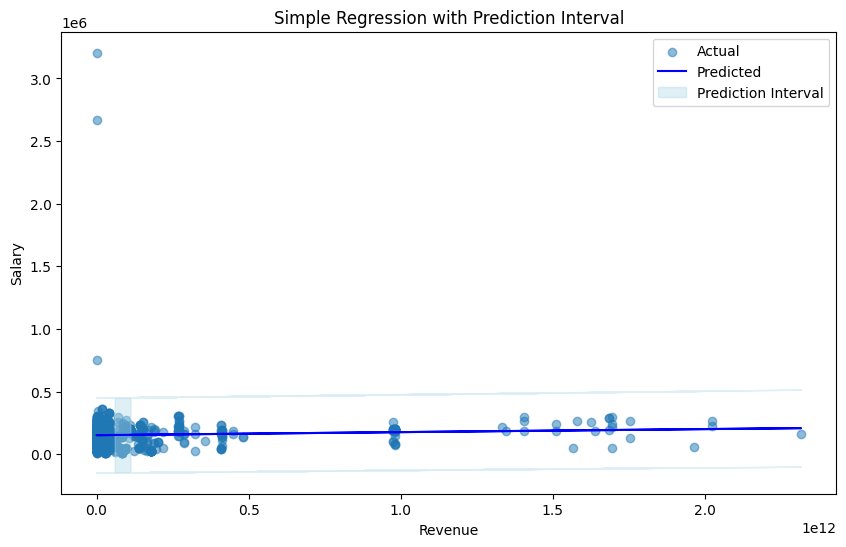

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_clean["revenue_num"], df_clean["salary_num"], label="Actual", alpha=0.5)
plt.plot(df_clean["revenue_num"], intervals_simple["mean"], color="blue", label="Predicted")
plt.fill_between(df_clean["revenue_num"],
                 intervals_simple["obs_ci_lower"],
                 intervals_simple["obs_ci_upper"],
                 color="lightblue", alpha=0.4, label="Prediction Interval")
plt.xlabel("Revenue")
plt.ylabel("Salary")
plt.title("Simple Regression with Prediction Interval")
plt.legend()
plt.show()


In [135]:
# Multiple regression
X_multi = sm.add_constant(df[["revenue_num", "company_size_num", "days_since_post"]])
model_multi = sm.OLS(y, X_multi).fit()
pred_multi = model_multi.get_prediction(X_multi)
intervals_multi = pred_multi.summary_frame(alpha=0.05)

MissingDataError: exog contains inf or nans

<h3>(2) Make a plot showing the predicted regression line from your simple regression with the dependent variable on the y-axis and independent variable on the x-axis. Also display prediction interval lines. (The easiest way to do this is probably starting by generating x-values from x-min to x-max, then getting predicted y's for that set. Then generate lower and upper prediction interval bounds for each x in the set. Note that the statistics, e.g., /bar{x}, should still be calculated using the collected data.)</h3>

In [ ]:
# todo